In [100]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from matplotlib.mlab import PCA as mlabPCA
from sklearn import preprocessing
from sklearn.decomposition import PCA 
import math
import warnings

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.5f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Introduction

Since I live in Tampa, looking closer at Florida crime data seems rewarding! On the FBI's site, we are able to download crime data for the past 23 years ([here](https://ucr.fbi.gov/crime-in-the-u.s), so we grabbed the [2016](https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-6/table-6-state-cuts/florida.xls) and [2017](https://ucr.fbi.gov/crime-in-the-u.s/2017/crime-in-the-u.s.-2017/tables/table-8/table-8-state-cuts/florida.xls) data.


## Read Data

In [4]:
# Read in the crime data for Florida for 2016, listed by city
florida_crime = pd.read_excel('./florida_2016.xls')
florida_crime_2017 = pd.read_excel('./florida_2017.xls')
florida_crime.columns = ['City', 'Population', 'Violent Crime', 'Murder', 'Rape', 'Robbery',
       'Assault', 'Property Crime', 'Burglary', 'Larceny-theft',
       'Motor Vehicle Theft', 'Arson']
florida_crime_2017.columns = florida_crime.columns
florida_crime.set_index('City', inplace=True)
florida_crime_2017.set_index('City', inplace=True)

In [12]:
florida_crime.describe()

,Population,Violent Crime,Murder,Rape,Robbery,Assault,Property Crime,Burglary,Larceny-theft,Motor Vehicle Theft,Arson
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,34807.492958,177.957746,2.436620,13.855634,48.545775,113.119718,1184.700704,194.750000,895.186620,94.764085,2.989437
std,73543.953812,486.837924,9.149689,39.400323,144.790679,303.056794,2795.544937,498.894018,2053.082453,264.172120,8.084135
min,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3954.500000,8.000000,0.000000,0.000000,1.000000,6.000000,93.000000,17.000000,66.750000,5.000000,0.000000
50%,12512.000000,42.000000,0.000000,3.000000,7.000000,26.000000,347.500000,59.000000,260.000000,18.000000,1.000000
75%,38386.750000,136.750000,2.000000,13.000000,32.000000,93.250000,1139.500000,173.000000,905.750000,77.500000,2.250000
max,880557.000000,5504.000000,106.000000,517.000000,1463.000000,3418.000000,31538.000000,5851.000000,22660.000000,3027.000000,83.000000


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


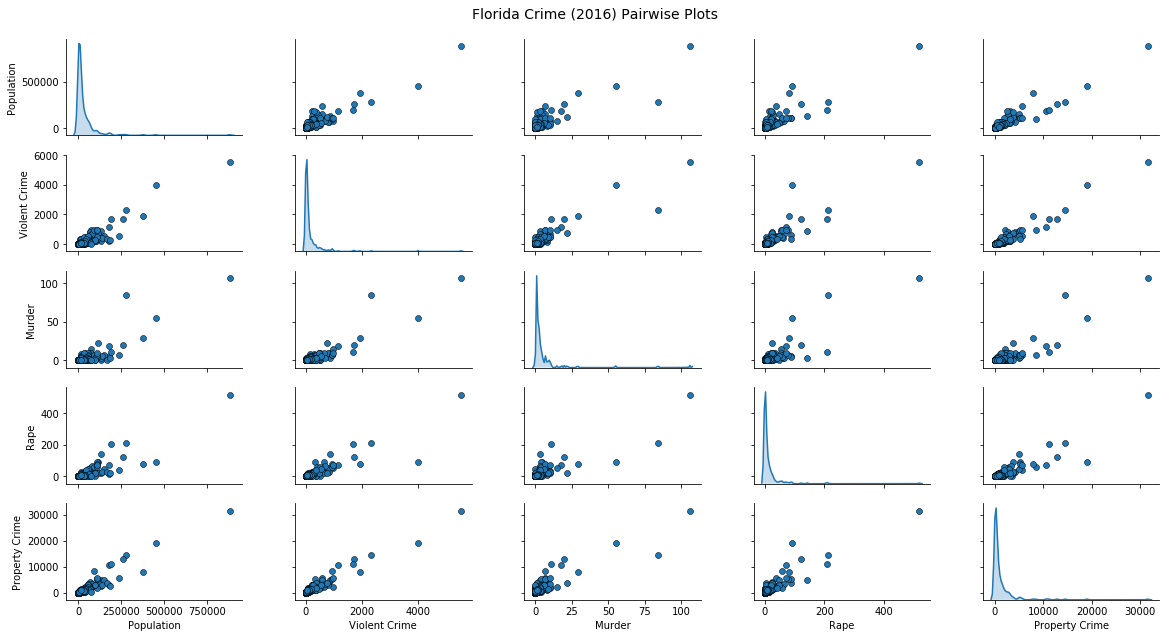

In [17]:
cols = ["Population", "Violent Crime", "Murder", "Rape", "Property Crime"]
pp = sns.pairplot(florida_crime[cols], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Florida Crime (2016) Pairwise Plots', fontsize=14)

## Transform Data

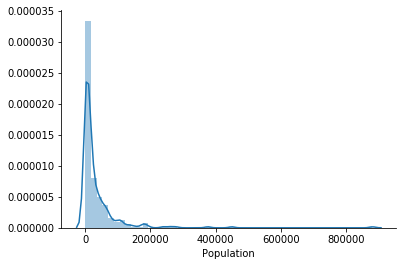

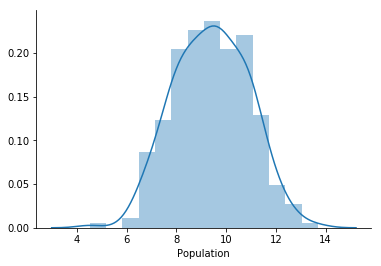

In [32]:
sns.distplot(florida_crime.Population)
sns.despine()
plt.show()
sns.distplot(np.log(florida_crime.Population))
sns.despine()

So the population variable suffers a lot from extreme outliers (metropolitan cities with very large populations), so we should transform it:
  1. Log transform
  2. square root

Population is left skewed, so to reduce this the log seems pretty good. *Might want to scale the data (eg mean of 0 and standard deviation of 1?*

In [33]:
florida_crime.Population.describe()

count       284.000000
mean      34807.492958
std       73543.953812
min          92.000000
25%        3954.500000
50%       12512.000000
75%       38386.750000
max      880557.000000
Name: Population, dtype: float64

In [49]:
# Log-transform the population variable
X = florida_crime.copy()
X["Log Population"] = np.log(florida_crime.Population)
X_2017 = florida_crime_2017.copy()
X_2017["Log Population"] = np.log(florida_crime_2017.Population)

threshold_low = X["Log Population"].quantile(0.1)
threshold_medium = X["Log Population"].quantile(0.9)

X["Population Low"] = (X["Log Population"] < threshold_low).values # the 10% quantile
X["Population Medium"] = (X["Log Population"] < threshold_medium).values # the 90% quantile
X["Population High"] = (X["Log Population"] >= threshold_medium).values
# there are 29 cities that fall in the low category, 255 in the medium and another 29 in the high

# we could update the thresholds, however for this example we are just going to use
# the thresholds obtained from the 2016 data. This results in a reduction of 1 city from the 
# low population group and one more in the high group. 
X_2017["Population Low"] = (X_2017["Log Population"] < threshold_low).values
X_2017["Population Medium"] = (X_2017["Log Population"] < threshold_medium).values
X_2017["Population High"] = (X_2017["Log Population"] >= threshold_medium).values

In [56]:
X.corr()

,Population,Violent Crime,Murder,Rape,Robbery,Assault,Property Crime,Burglary,Larceny-theft,Motor Vehicle Theft,Arson,Log Population,Population Low,Population Medium,Population High
Population,1.000000,0.929634,0.854360,0.876044,0.898012,0.924658,0.945365,0.919688,0.943289,0.936257,0.899684,0.635897,-0.154965,-0.683311,0.683311
Violent Crime,0.929634,1.000000,0.916978,0.893219,0.975464,0.996568,0.968097,0.953686,0.961277,0.972806,0.893976,0.534123,-0.121455,-0.573448,0.573448
Murder,0.854360,0.916978,1.000000,0.849622,0.863262,0.919967,0.890373,0.936081,0.869960,0.893257,0.797951,0.426851,-0.089966,-0.456230,0.456230
Rape,0.876044,0.893219,0.849622,1.000000,0.814050,0.890302,0.910366,0.936060,0.896968,0.894967,0.760974,0.507238,-0.117027,-0.571868,0.571868
Robbery,0.898012,0.975464,0.863262,0.814050,1.000000,0.957345,0.949392,0.907444,0.948380,0.962424,0.876829,0.517095,-0.111900,-0.579294,0.579294
Assault,0.924658,0.996568,0.919967,0.890302,0.957345,1.000000,0.956348,0.948519,0.948234,0.959602,0.894159,0.532144,-0.123715,-0.556310,0.556310
Property Crime,0.945365,0.968097,0.890373,0.910366,0.949392,0.956348,1.000000,0.972749,0.998171,0.987687,0.859876,0.589585,-0.139177,-0.652440,0.652440
Burglary,0.919688,0.953686,0.936081,0.936060,0.907444,0.948519,0.972749,1.000000,0.957751,0.961979,0.824676,0.543398,-0.126575,-0.592958,0.592958
Larceny-theft,0.943289,0.961277,0.869960,0.896968,0.948380,0.948234,0.998171,0.957751,1.000000,0.982438,0.859677,0.601136,-0.143680,-0.664152,0.664152
Motor Vehicle Theft,0.936257,0.972806,0.893257,0.894967,0.962424,0.959602,0.987687,0.961979,0.982438,1.000000,0.860836,0.541061,-0.117129,-0.622864,0.622864


In [95]:
# In order to explain 99% of the variance in all predictors, we are going to need 9 components
# Now PCA all features (crimes + the log of population)
# not trying to reduce dimensionality just want to eliminate collinearity
pca = PCA(n_components=9)

# Do not include these in the PCA 
cols = ["Population", "Property Crime", "Population Low", "Population Medium", "Population High"]
pca.fit(X.loc[:, ~X.columns.isin(cols)].values)
X_new = pca.transform(X.loc[:, ~X.columns.isin(cols)].values)
X_new = pd.DataFrame(X_new, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9"])
print(X_new.corr())
X_new["Log_Population"] = X["Log Population"].values
X_new["Population_low"] = X["Population Low"].values
X_new["Population_medium"] = X["Population Medium"].values
X_new["Population_high"] = X["Population High"].values
X_new["Property_Crime"] = X["Property Crime"].values

              PC1           PC2           PC3           PC4           PC5  \
PC1  1.000000e+00  1.800408e-14  1.881650e-16 -2.740886e-16 -9.792552e-16   
PC2  1.800408e-14  1.000000e+00  2.947285e-16  5.010925e-17 -4.844560e-16   
PC3  1.881650e-16  2.947285e-16  1.000000e+00  1.723716e-16  2.408615e-16   
PC4 -2.740886e-16  5.010925e-17  1.723716e-16  1.000000e+00  4.073140e-16   
PC5 -9.792552e-16 -4.844560e-16  2.408615e-16  4.073140e-16  1.000000e+00   
PC6 -5.936393e-15  1.946965e-15  1.987364e-15  1.417561e-16 -6.927130e-16   
PC7  9.830052e-15 -1.505095e-15  1.695081e-15 -5.576432e-17 -3.010046e-16   
PC8 -2.307967e-13  4.254744e-14 -2.668237e-14  6.162458e-15  7.984032e-15   
PC9 -4.848011e-14  1.079356e-14 -6.309317e-15  1.528034e-15  2.186520e-15   

              PC6           PC7           PC8           PC9  
PC1 -5.936393e-15  9.830052e-15 -2.307967e-13 -4.848011e-14  
PC2  1.946965e-15 -1.505095e-15  4.254744e-14  1.079356e-14  
PC3  1.987364e-15  1.695081e-15 -2.668237e-

Perfect! We got rid of the correlation (collinearity) among input features!

In [96]:
X_new.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Log_Population,Population_low,Population_medium,Population_high,Property_Crime
0,-710.791630,-34.633100,-9.516175,-6.361568,6.154842,1.196424,0.203874,0.534814,-0.146775,9.200290,False,True,False,306
1,276.522302,89.188442,-76.786855,34.708791,-19.017915,-2.534829,1.757042,-5.669054,-1.149684,10.680493,False,True,False,1535
2,-932.214184,-39.529157,5.610612,-20.971221,6.517278,0.810992,-0.197180,-0.549552,1.013059,7.736744,False,True,False,26
3,552.298040,-20.714399,-184.607732,27.643026,-9.686563,-10.691624,2.745198,7.035534,-0.217227,10.815690,False,True,False,2008
4,-825.505350,-124.108758,-26.954032,2.561760,-4.206286,-6.508718,-1.172323,1.281694,0.058373,8.973732,False,True,False,189


In [97]:
X_new.corr()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Log_Population,Population_low,Population_medium,Population_high,Property_Crime
PC1,1.000000e+00,1.800408e-14,1.881650e-16,-2.740886e-16,-9.792552e-16,-5.936393e-15,9.830052e-15,-2.307967e-13,-4.848011e-14,0.595560,-0.141603,-0.656653,0.656653,0.999247
PC2,1.800408e-14,1.000000e+00,2.947285e-16,5.010925e-17,-4.844560e-16,1.946965e-15,-1.505095e-15,4.254744e-14,1.079356e-14,0.182544,-0.064945,-0.259799,0.259799,-0.018011
PC3,1.881650e-16,2.947285e-16,1.000000e+00,1.723716e-16,2.408615e-16,1.987364e-15,1.695081e-15,-2.668237e-14,-6.309317e-15,-0.013220,0.009780,0.038750,-0.038750,-0.031957
PC4,-2.740886e-16,5.010925e-17,1.723716e-16,1.000000e+00,4.073140e-16,1.417561e-16,-5.576432e-17,6.162458e-15,1.528034e-15,0.215586,-0.117689,-0.022676,0.022676,-0.012020
PC5,-9.792552e-16,-4.844560e-16,2.408615e-16,4.073140e-16,1.000000e+00,-6.927130e-16,-3.010046e-16,7.984032e-15,2.186520e-15,-0.029136,0.018086,-0.002895,0.002895,0.003837
PC6,-5.936393e-15,1.946965e-15,1.987364e-15,1.417561e-16,-6.927130e-16,1.000000e+00,-5.508760e-15,-3.422948e-15,-2.065517e-16,-0.065770,0.035740,-0.036299,0.036299,-0.000554
PC7,9.830052e-15,-1.505095e-15,1.695081e-15,-5.576432e-17,-3.010046e-16,-5.508760e-15,1.000000e+00,4.411959e-16,-2.641062e-16,0.065255,-0.009922,-0.124345,0.124345,0.000008
PC8,-2.307967e-13,4.254744e-14,-2.668237e-14,6.162458e-15,7.984032e-15,-3.422948e-15,4.411959e-16,1.000000e+00,-5.398909e-16,0.170836,-0.076396,-0.130835,0.130835,0.000025
PC9,-4.848011e-14,1.079356e-14,-6.309317e-15,1.528034e-15,2.186520e-15,-2.065517e-16,-2.641062e-16,-5.398909e-16,1.000000e+00,-0.725752,0.600143,0.131169,-0.131169,-0.000001
Log_Population,5.955601e-01,1.825443e-01,-1.322034e-02,2.155859e-01,-2.913561e-02,-6.576976e-02,6.525514e-02,1.708357e-01,-7.257521e-01,1.000000,-0.573821,-0.567092,0.567092,0.589585


In [52]:
# PC9 and Population_Low
# PC1 and Population_Medium, and Log_Population (not including this anyways)
# PC1 and Population_High

array([[  42,    0,    6, ...,  219,   23,    1],
       [ 152,    8,   16, ..., 1185,   76,    4],
       [   4,    0,    0, ...,   10,   10,    0],
       ...,
       [ 100,    2,   12, ...,  766,   53,    2],
       [  54,    0,    6, ...,  347,   19,    0],
       [  51,    1,    7, ...,  772,   21,    5]])

In [115]:
formula1 = "Property_Crime ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9"
# Fit the model to our data using the formula.
lm1 = smf.ols(formula=formula1, data=X_new).fit()
print("Model Parameters\n===========================================")
print(lm1.params)
print("p-values\n===========================================")
print(lm1.pvalues)
print("\n\nR-Squared: {}".format(lm1.rsquared))

Model Parameters
Intercept   1184.70070
PC1            1.27014
PC2           -0.28437
PC3           -0.75455
PC4           -0.76040
PC5            0.38206
PC6           -0.10854
PC7            0.00624
PC8            0.02292
PC9           -0.00308
dtype: float64
p-values
Intercept   0.00000
PC1         0.00000
PC2         0.00000
PC3         0.00000
PC4         0.00000
PC5         0.00000
PC6         0.00000
PC7         0.00000
PC8         0.00000
PC9         0.00000
dtype: float64


R-Squared: 1.0


*The above does not make sense...*

In [162]:
y_hat2 = lm1.predict(X_new_2017)

In [116]:
lm1.resid.mean()

-3.5480225955978596e-14

In [118]:
formula_new = "Property_Crime ~ PC1 + PC2 + Population_medium + Population_high"
# Fit the model to our data using the formula.
lm_new = smf.ols(formula=formula_new, data=X_new).fit()
print("Model Parameters\n===========================================")
print(lm_new.params)
print("p-values\n===========================================")
print(lm_new.pvalues)
print("\n\nR-Squared: {}".format(lm_new.rsquared))

Model Parameters
Intercept                   794.48717
Population_medium[T.True]   388.40937
Population_high[T.True]     406.07780
PC1                           1.26854
PC2                          -0.29223
dtype: float64
p-values
Intercept                   0.00000
Population_medium[T.True]   0.00000
Population_high[T.True]     0.00000
PC1                         0.00000
PC2                         0.00000
dtype: float64


R-Squared: 0.9988211040658992


In [119]:
lm_new.resid.mean()

-2.622002771396426e-13

In [120]:
y_hat = lm_new.predict(X_new)

In [123]:
pca2 = PCA(n_components=9)

# Do not include these in the PCA 
cols = ["Population", "Property Crime", "Population Low", "Population Medium", "Population High"]
pca2.fit(X_2017.loc[:, ~X.columns.isin(cols)].values)
X_new_2017 = pca.transform(X_2017.loc[:, ~X_2017.columns.isin(cols)].values)
X_new_2017 = pd.DataFrame(X_new_2017, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9"])
X_new_2017["Log_Population"] = X_2017["Log Population"].values
X_new_2017["Population_low"] = X_2017["Population Low"].values
X_new_2017["Population_medium"] = X_2017["Population Medium"].values
X_new_2017["Population_high"] = X_2017["Population High"].values
X_new_2017["Property_Crime"] = X_2017["Property Crime"].values
X_new_2017.corr()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Log_Population,Population_low,Population_medium,Population_high,Property_Crime
PC1,1.00000,0.22358,0.32178,0.28913,0.54078,0.06939,0.22298,-0.14779,0.10639,0.58354,-0.13237,-0.64034,0.64034,0.99961
PC2,0.22358,1.00000,-0.19136,-0.02423,0.02511,-0.09671,-0.12171,0.17618,-0.00434,0.31542,-0.08824,-0.37536,0.37536,0.21532
PC3,0.32178,-0.19136,1.00000,0.30205,0.37803,-0.06441,0.06781,-0.36280,-0.02953,0.19498,-0.03139,-0.23287,0.23287,0.30345
PC4,0.28913,-0.02423,0.30205,1.00000,0.03379,0.21212,-0.11213,-0.13904,0.17947,0.22853,-0.09063,-0.12538,0.12538,0.27207
PC5,0.54078,0.02511,0.37803,0.03379,1.00000,-0.25782,0.18500,-0.20451,-0.01115,0.30958,-0.05049,-0.37400,0.37400,0.54221
PC6,0.06939,-0.09671,-0.06441,0.21212,-0.25782,1.00000,-0.05567,-0.13979,-0.03969,0.01824,0.00321,-0.11730,0.11730,0.06856
PC7,0.22298,-0.12171,0.06781,-0.11213,0.18500,-0.05567,1.00000,-0.23510,0.03524,0.07919,-0.00858,-0.06989,0.06989,0.22852
PC8,-0.14779,0.17618,-0.36280,-0.13904,-0.20451,-0.13979,-0.23510,1.00000,-0.02333,0.07682,-0.05961,-0.00997,0.00997,-0.14295
PC9,0.10639,-0.00434,-0.02953,0.17947,-0.01115,-0.03969,0.03524,-0.02333,1.00000,-0.68425,0.55743,0.15060,-0.15060,0.10588
Log_Population,0.58354,0.31542,0.19498,0.22853,0.30958,0.01824,0.07919,0.07682,-0.68425,1.00000,-0.56540,-0.57350,0.57350,0.57935


In [125]:
y_hat_2017 = lm_new.predict(X_new_2017)
y_hat_2017.index = florida_crime.index

In [127]:
resids_2017 = pd.DataFrame(X_2017["Property Crime"].values - y_hat_2017.values, columns=["residual"])
resids_2017["City"] = florida_crime_2017.index
resids_2017.set_index('City', inplace=True)

In [128]:
resids_2017.head()

,residual
City,
Alachua,-4.83258
Altamonte Springs,-34.10656
Apalachicola,4.32905
Apopka,57.57240
Arcadia,4.93554


In [156]:
y_hat_2017

City
Alachua                 270.83258
Altamonte Springs      1403.10656
Apalachicola              0.67095
Apopka                 1823.42760
Arcadia                 170.06446
Atlantic Beach          350.98991
Atlantis                 47.40587
Auburndale              490.79205
Aventura               2018.14046
Bal Harbour Village      74.84829
Bartow                  675.77104
Bay Harbor Islands       41.81728
Belleair                 87.78846
Belleair Beach           12.63685
Belleair Bluffs          24.75109
Belle Glade             935.48725
Belle Isle               72.56699
Belleview               260.22371
Biscayne Park            77.91333
Blountstown              45.83854
Boca Raton             2402.28058
Bowling Green            17.77220
Boynton Beach            44.79384
Bradenton              3169.57029
Bradenton Beach        1558.95119
Brooksville              22.37981
Bunnell                 336.51628
Cape Coral              121.99230
Carrabelle             2773.44057
Casselber

In [152]:
print("RESIDUALS\n==========================")
print("2016\n--------------------------")
print("Average: {}".format(lm_new.resid.mean()))
print("Standard Deviation: {}".format(round(lm_new.resid.std(),2)))
print("\n2017\n--------------------------")
print("Average: {}".format(round(resids_2017.residual.dropna().mean(),2)))
print("Standard Deviation: {}".format(round(resids_2017.residual.std(),2)))

RESIDUALS
2016
--------------------------
Average: -2.622002771396426e-13
Standard Deviation: 95.99

2017
--------------------------
Average: -6.69
Standard Deviation: 79.97


In [155]:
X_new.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,Log_Population,Population_low,Population_medium,Population_high,Property_Crime
0,-710.79163,-34.63310,-9.51618,-6.36157,6.15484,1.19642,0.20387,0.53481,-0.14678,9.20029,False,True,False,306
1,276.52230,89.18844,-76.78686,34.70879,-19.01792,-2.53483,1.75704,-5.66905,-1.14968,10.68049,False,True,False,1535
2,-932.21418,-39.52916,5.61061,-20.97122,6.51728,0.81099,-0.19718,-0.54955,1.01306,7.73674,False,True,False,26
3,552.29804,-20.71440,-184.60773,27.64303,-9.68656,-10.69162,2.74520,7.03553,-0.21723,10.81569,False,True,False,2008
4,-825.50535,-124.10876,-26.95403,2.56176,-4.20629,-6.50872,-1.17232,1.28169,0.05837,8.97373,False,True,False,189


# Conclusion

This data poses some interesting issues when it comes to simple linear regression, mainly the fact that the input features are all collinear; an assumption that must hold in order to get meaningful results from a linear regression model. To combat this, we first log-transformed the population, and then used PCA to create uncorrelated components from this log transform as well as the 9 crime counts each city saw over that year. We then created 3 dummy variables to indicate the population group that that city fell into. This serves as an indicator of whether that city is a outlier when it comes to population (using the 10% and 90% quantile values). We then combined our principal components with these 3 indicator variables to create a linear model, initially containing all 9 components as well as the 3 dummy variables. Then, by looking at the p-values of the model, we reduced the formula down to only 4 variables: PC1, PC2, Population_medium and Population_high. 

By looking at the residuals for both years, we can identify areas that we need to improve on: those cities with very low or very high populations. While the average error this model made on 2016 crime data was negligible, the standard deviation is quite high, especially for cities with low populations. Take for instance Apalachicola, where the population is only 2,345 that saw a total of 5 property crimes in all of 2016, but the model predicts 0.69 property crimes in 2017. This suggests that we may want to have different models for extreme populations (low and high). 

In [158]:
X_2017.loc["Apalachicola",:]

Population               2345
Violent Crime               3
Murder                      0
Rape                        0
Robbery                     0
Assault                     3
Property Crime              5
Burglary                    1
Larceny-theft               4
Motor Vehicle Theft         0
Arson                       0
Log Population        7.76004
Population Low          False
Population Medium        True
Population High         False
Name: Apalachicola, dtype: object